In [124]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
# import cv2
import os
from xml.dom import minidom
import copy
import random


In [2]:
doc = minidom.parse("../input/alldata/data/lineStrokes/lineStrokes/a01/a01-001/a01-001z-01.xml")

In [ ]:
strokes = doc.getElementsByTagName('Stroke')

In [ ]:
points = strokes[0].getElementsByTagName('Point')

In [ ]:
points[0].getAttribute("x")

In [122]:
def n_grams(data, n):
    data_points = []
    for i in range(0,data.shape[0]-n-1):
        data_points.append((data[i:i+n],data[i+n]))
    return data_points

def get(po,att):
    return int(po.getAttribute(att))

def read_strokes(doc):
    strokes = doc.getElementsByTagName('Stroke')
    ret = []
    for stroke in strokes:
        points = stroke.getElementsByTagName('Point')
        for i in range(len(points)-1):
            ret.append([get(points[i],'x') , get(points[i],'y'), 0])
        ret.append([get(points[-1],'x') , get(points[-1],'y'), 1])
    return np.array(ret,dtype='float')

def create_data(path):
    f = open(path, 'r')
    arr = f.readlines()
    data = []
    for useri in arr:
        user = useri.replace(' ','')
        user = user.replace('\n','')
        p = '../input/alldata/data/lineStrokes/lineStrokes/'+user[:3]+'/'+user[:7]+'/'
        fi = [x for x in os.listdir(p)]
        fi.sort()
        for file in fi:
#             print(file[:-7], user, len(user))
            if file[:-7] == user:
                d = read_strokes(doc)
                da = n_grams(d, 100)
                for po in da:
                    data.append(po)
    return data

In [5]:
train_data = create_data('../input/alldata/data/trainset.txt')

In [6]:
test_data = create_data('../input/alldata/data/testset_v.txt')

In [125]:
random.shuffle(train_data)

In [111]:
co =  len([i for i in train_data if i[1][2]==1])
co

91188

In [131]:
train = []
cur = 0
for i in train_data:
#     print(i[0])
    if i[0][1][2] == 0 and cur<co:
        train.append(i)
        cur+=1
    elif i[0][1][2]==1:
        train.append(i)
len(train)

187740

In [132]:
def mean_shift_data(data):
#     d = []
    new_data = []
    for i in range(len(data)):
        if i%10000 == 0:
            print('Got this  ',i)
        x1 = data[i][0][0][0]
        x2 = data[i][0][0][1]
        nd = np.zeros((101,3))
        for j in range(100):
            nd[j][0] = data[i][0][j][0] - x1
            nd[j][1] = data[i][0][j][1] - x2
            x1 = data[i][0][j][0]
            x2 = data[i][0][j][1]
        nd[100][0] = data[i][1][0] - x1
        nd[100][1] = data[i][1][1] - x2
        ux = 1.0*(nd[:,0].sum())/101.0
        uy = 1.0*(nd[:,1].sum())/101.0
        sx = ((1.0*(np.sum(nd[:,0]**2))/101.0) - ux**2)**0.5
        sy = ((1.0*(np.sum(nd[:,1]**2))/101.0) - uy**2)**0.5
        if sx == 0:
            sx = 1
        if sy == 0:
            sy = 1
        for j in range(101):
            nd[j][0] = (nd[j][0]-ux)/sx
            nd[j][1] = (nd[j][1]-uy)/sy  
        new_data.append((nd[:100],nd[100]))
    return new_data

def mean_shift_data1(data):
#     d = []
    new_data = []
    for i in range(len(data)):
        if i%10000 == 0:
            print('Got this  ',i)
        x1 = data[i][0][0][0]
        x2 = data[i][0][0][1]
        nd = np.zeros((101,3))
        for j in range(100):
            nd[j][0] = data[i][0][j][0] - x1
            nd[j][1] = data[i][0][j][1] - x2
            x1 = data[i][0][j][0]
            x2 = data[i][0][j][1]
        nd[100][0] = data[i][1][0] - x1
        nd[100][1] = data[i][1][1] - x2
        ux = 1.0*(nd[:,0].sum())/101.0
        uy = 1.0*(nd[:,1].sum())/101.0
        sx = ((1.0*(np.sum(nd[:,0]**2))/101.0) - ux**2)**0.5
        sy = ((1.0*(np.sum(nd[:,1]**2))/101.0) - uy**2)**0.5
        if sx == 0:
            sx = 1
        if sy == 0:
            sy = 1
        for j in range(101):
            nd[j][0] = (nd[j][0]-ux)/sx
            nd[j][1] = (nd[j][1]-uy)/sy  
        new_data.append((nd[:100],nd[100],ux,uy,sx,sy))
    return new_data

In [14]:
random.shuffle(test_data)
data_test = mean_shift_data1(test_data[0:100000])

Got this   0
Got this   10000
Got this   20000
Got this   30000
Got this   40000
Got this   50000
Got this   60000
Got this   70000
Got this   80000
Got this   90000


In [137]:
random.shuffle(train)
data_train = mean_shift_data(train[:30000])

Got this   0
Got this   10000
Got this   20000


In [18]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np 

# %matplotlib inline

# for reproducibility
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [168]:
def loss_function(output, label):
    pro = torch.zeros([label.shape[0]]).to(device)
    for i in range(20):
        w = output[:,i]
        ux = output[:,20+i]
        uy = output[:,40+i]
        sx = output[:,60+i]
        sy = output[:,80+i]
        r = output[:,100+i]
#         print(w,ux,uy,sx,sy,r)
        Z = ((label[:,0]-ux)**2)/(sx**2) + ((label[:,1]-uy)**2)/(sy**2) - 2*r*((label[:,0]-ux)/sx)*((label[:,1]-uy)/sy)
#         print(Z.shape)
        N = (torch.exp(-Z/(2*(1-r**2))))/(2*3.14*sx*sy*((1-r**2)**0.5))
#         print(r.shape, N.shape,w.shape)
        pro += w*N
#     print(pro)
    pro = label[:,2]*pro*output[:,120]+(1-label[:,2])*(1-pro)*output[:,120]
    pro = torch.add(pro, 1e-10)
    return torch.mean(-torch.sum(torch.log(pro))), pro

def get_var2(output):
#     pro = torch.zeros([label.shape[0]]).to(device)
    w = torch.zeros([output.shape[0],20]).to(device)
    ux = torch.zeros([output.shape[0],20]).to(device)
    uy = torch.zeros([output.shape[0],20]).to(device)
    sx = torch.zeros([output.shape[0],20]).to(device)
    sy = torch.zeros([output.shape[0],20]).to(device)
    r = torch.zeros([output.shape[0],20]).to(device)
    for i in range(20):
        w[:,i] = output[:,i]
        ux[:,i] = output[:,20+i]
        uy[:,i] = output[:,40+i]
        sx[:,i] = output[:,60+i]
        sy[:,i] = output[:,80+i]
        r[:,i] = output[:,100+i]
    return w,ux, uy, sx,sy,r, output[:,120]

def loss_function2(model,output,label):
    log_pi, mu1, mu2, sigma1, sigma2, rho, fl = get_var2(output)
    label = label.view(-1,3)
    x1, x2, x_eos = label.split(1,dim=1)
    loss1 = - logP_gaussian(model, x1, x2, mu1, mu2, sigma1, sigma2, rho, log_pi)
    loss2 = torch.sum(-(x_eos)*torch.log(fl) - (1-x_eos)*torch.log(fl))
    return (loss1+loss2)/label.shape[0]

def logsumexp(x):
    x_max, _ = x.max(dim=1,keepdim=True)
    x_max_expand = x_max.expand(x.size())
    res =  x_max + torch.log((x-x_max_expand).exp().sum(dim=1, keepdim=True))
    return res

def logP_gaussian(model,x1, x2, mu1, mu2, sigma1, sigma2, rho, log_pi):
    x1, x2 = x1.repeat(1,20), x2.repeat(1,20)
    z_tmp1, z_tmp2 = (x1-mu1)/sigma1, (x2-mu2)/sigma2
    log_pi = torch.log(log_pi)/log_pi.sum()
    log_sigma1 = torch.log(sigma1)
    log_sigma2 = torch.log(sigma2)
    z = z_tmp1**2 + z_tmp2**2 - 2*rho*z_tmp1*z_tmp2
  # part one
    log_gaussian = - np.log(np.pi*2)-log_sigma1 - log_sigma2 - 0.5*(1-rho**2).log()
  # part two
    log_gaussian += - z/2/(1-rho**2)
  # part three
    log_gaussian = logsumexp(log_gaussian + log_pi)
    return log_gaussian.sum()

In [24]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=2, dropout=0.4, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(300,400)
        self.fc2 = nn.Linear(400, 121)
        self.flat = nn.Flatten()
    def forward(self, x):
        x = x.float()
        batch_size = x.shape[0]
        hidden = (torch.zeros(2, batch_size, 3).to(device), torch.zeros(2, batch_size, 3).to(device))
        out, hidden = self.lstm(x,hidden)
        x = (F.relu(self.flat(out)))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x
    
    def forward2(self, x, hidden):
        x = x.float()
        batch_size = x.shape[0]
#         hidden = (torch.zeros(2, batch_size, 3), torch.zeros(2, batch_size, 3))
        out, hidden = self.lstm(x,hidden)
        x = (F.relu(self.flat(out)))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x, hidden
    


In [235]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.c1 = nn.Conv1d(3,10,5, padding=2)
        self.lstm = nn.LSTM(input_size=10, hidden_size=256, num_layers=2, dropout=0.4, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256,121)
        self.fc2 = nn.Linear(400, 121)
        self.flat = nn.Flatten()
    def forward(self, x):
        x = x.float()
        seq_len = x.shape[1]
        batch_size = x.shape[0]
        x = self.dropout(F.relu(self.c1(x.view(batch_size,3,seq_len))))
        hidden = (torch.zeros(2, batch_size, 256).to(device), torch.zeros(2, batch_size, 256).to(device))
        x = x.view(batch_size,seq_len,10)
        out, hidden = self.lstm(x,hidden)
#         x = (F.relu(self.flat(out)))
#         x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc1(F.relu(out[:,-1]))
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x
    
    def forward2(self, x, hidden):
        x = x.float()
        seq_len = x.shape[1]
        batch_size = x.shape[0]
        x = self.dropout(F.relu(self.c1(x.view(batch_size,3,seq_len))))
#         hidden = (torch.zeros(2, batch_size, 3), torch.zeros(2, batch_size, 3))
        out, hidden = self.lstm(x.view(batch_size,seq_len,10),hidden)
#         x = (F.relu(self.flat(out)))
#         x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc1(F.relu(out[:,-1]))
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x, hidden

In [166]:
def trainvalAdam(model, train_data, valid_data, device, batch_size=128, num_iters=1, learn_rate=0.01, classes = 6):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
#     val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
#     criterion = nn.CrossEntropyLoss()
#     criterion = loss_function()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.90, 0.98), eps=1e-08, weight_decay=0, amsgrad=False)
    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []
    best = 1e9
    prev = 0
    n = 0 # the number of iterations
    for n in tqdm(range(num_iters)):
        tot_loss = 0
        fl = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss = loss_function2(model, out, labels) # compute the total loss
#             optimizer.zero_grad()         # a clean up step for PyTorch
            tot_loss += float(loss)*out.shape[0]
#                 break
            loss.backward()               # backward pass (compute parameter updates)
            threshold = 10.0
            for p in model.parameters():
                torch.nn.utils.clip_grad_norm_(p, threshold)
            optimizer.step()              # make the updates for each parameter

        # save the current training information
        # if n % 10 != 10:
        iters.append(n)
        losses.append(float(tot_loss))        # compute *average* loss
        print('Epoch no ',n,'   and training loss: ',tot_loss)
#         if fl == 1:
#             print('Early stopping\n')
#             break
#         train_accuracy = get_accuracy(model, train_data, device)
#         val_accuracy = get_accuracy(model, valid_data, device)
#         for im, lb in val_loader:
#             im, lb = im.to(device), lb.to(device)
#             val_out = model(im)
#             val_loss = criterion(val_out, lb)
#         vl = float(val_loss)/batch_size
#         val_losses.append(float(val_loss)/batch_size)
#         train_acc.append(train_accuracy) # compute training accuracy 
#         val_acc.append(val_accuracy)   # compute validation accuracy
#         if vl<best:
#           prev = n
#           best = vl
#         if (n-prev)>20:
#             print('Early stopping ')
#             break
    return iters, val_losses, losses, val_acc, train_acc 


In [230]:
model4 = RNN3()
model4.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model4, data_train, data_train, device, num_iters=10)

 10%|█         | 1/10 [00:10<01:36, 10.69s/it]

Epoch no  0    and training loss:  493697.6014137864


 20%|██        | 2/10 [00:21<01:24, 10.52s/it]

Epoch no  1    and training loss:  -20896.235750813037


 30%|███       | 3/10 [00:31<01:13, 10.56s/it]

Epoch no  2    and training loss:  -34868.078089900315


 40%|████      | 4/10 [00:42<01:02, 10.47s/it]

Epoch no  3    and training loss:  -39378.41344942688


 50%|█████     | 5/10 [00:52<00:51, 10.39s/it]

Epoch no  4    and training loss:  -40420.55804111436


 60%|██████    | 6/10 [01:02<00:41, 10.45s/it]

Epoch no  5    and training loss:  -35755.86025415847


 70%|███████   | 7/10 [01:13<00:31, 10.40s/it]

Epoch no  6    and training loss:  -40012.3709313911


 80%|████████  | 8/10 [01:23<00:20, 10.38s/it]

Epoch no  7    and training loss:  -39479.096515046054


 90%|█████████ | 9/10 [01:34<00:10, 10.49s/it]

Epoch no  8    and training loss:  -39751.47675942078


100%|██████████| 10/10 [01:44<00:00, 10.46s/it]

Epoch no  9    and training loss:  -40842.39591970417


Text(0, 0.5, 'Training loss')

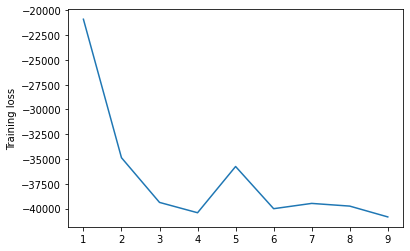

In [231]:
plt.plot(iters[1:], losses[1:])
plt.ylabel('Training loss')

In [234]:
torch.save(model4.state_dict(), 'modified_cnn_model0')

In [236]:
model4 = RNN3()
model4.load_state_dict(torch.load('modified_cnn_model0'))
model4.to(device)

RNN3(
  (c1): Conv1d(3, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (lstm): LSTM(10, 256, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=121, bias=True)
  (fc2): Linear(in_features=400, out_features=121, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [35]:
model = RNN()
model.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model, data_train, data_train, device, num_iters=60)

  2%|▏         | 1/60 [00:35<35:19, 35.92s/it]

Epoch no  0    and training loss:  524820.8582914154


  3%|▎         | 2/60 [01:11<34:32, 35.74s/it]

Epoch no  1    and training loss:  34.61634214271756


  5%|▌         | 3/60 [01:47<34:00, 35.80s/it]

Epoch no  2    and training loss:  22.61880125099854


  7%|▋         | 4/60 [02:23<33:25, 35.82s/it]

Epoch no  3    and training loss:  20.864528475424972


  8%|▊         | 5/60 [02:58<32:44, 35.72s/it]

Epoch no  4    and training loss:  19.889787731340082


 10%|█         | 6/60 [03:34<32:06, 35.67s/it]

Epoch no  5    and training loss:  19.114460959289026


 12%|█▏        | 7/60 [04:10<31:31, 35.70s/it]

Epoch no  6    and training loss:  18.12398128072245


 13%|█▎        | 8/60 [04:46<30:59, 35.76s/it]

Epoch no  7    and training loss:  16.905264164262825


 15%|█▌        | 9/60 [05:21<30:21, 35.72s/it]

Epoch no  8    and training loss:  16.058360447688187


 17%|█▋        | 10/60 [05:57<29:46, 35.74s/it]

Epoch no  9    and training loss:  15.589882663761257


 18%|█▊        | 11/60 [06:33<29:13, 35.79s/it]

Epoch no  10    and training loss:  15.438301700204022


 20%|██        | 12/60 [07:08<28:35, 35.74s/it]

Epoch no  11    and training loss:  15.43966546166973


 22%|██▏       | 13/60 [07:45<28:07, 35.91s/it]

Epoch no  12    and training loss:  15.432902099063154


 23%|██▎       | 14/60 [08:20<27:27, 35.81s/it]

Epoch no  13    and training loss:  15.429531747943336


 25%|██▌       | 15/60 [08:56<26:51, 35.81s/it]

Epoch no  14    and training loss:  15.438397124163746


 27%|██▋       | 16/60 [09:32<26:16, 35.83s/it]

Epoch no  15    and training loss:  15.422634714713311


 28%|██▊       | 17/60 [10:08<25:36, 35.73s/it]

Epoch no  16    and training loss:  15.42557012726282


 30%|███       | 18/60 [10:43<25:02, 35.76s/it]

Epoch no  17    and training loss:  15.44166826844483


 32%|███▏      | 19/60 [11:19<24:25, 35.75s/it]

Epoch no  18    and training loss:  15.431927391981066


 33%|███▎      | 20/60 [11:55<23:50, 35.77s/it]

Epoch no  19    and training loss:  15.431139608329083


 35%|███▌      | 21/60 [12:31<23:16, 35.81s/it]

Epoch no  20    and training loss:  15.435997707059384


 37%|███▋      | 22/60 [13:06<22:38, 35.75s/it]

Epoch no  21    and training loss:  15.443985708021582


 38%|███▊      | 23/60 [13:42<22:04, 35.80s/it]

Epoch no  22    and training loss:  15.4336306046748


 40%|████      | 24/60 [14:18<21:28, 35.79s/it]

Epoch no  23    and training loss:  15.422623300859444


 42%|████▏     | 25/60 [14:54<20:54, 35.85s/it]

Epoch no  24    and training loss:  15.432463302254561


 43%|████▎     | 26/60 [15:30<20:17, 35.81s/it]

Epoch no  25    and training loss:  15.436749202508212


 45%|████▌     | 27/60 [16:06<19:48, 36.00s/it]

Epoch no  26    and training loss:  15.42247070125936


 47%|████▋     | 28/60 [16:42<19:08, 35.89s/it]

Epoch no  27    and training loss:  15.438734663736989


 48%|████▊     | 29/60 [17:18<18:30, 35.81s/it]

Epoch no  28    and training loss:  15.436436353838324


 50%|█████     | 30/60 [17:53<17:54, 35.81s/it]

Epoch no  29    and training loss:  15.425337413507709


 52%|█████▏    | 31/60 [18:29<17:18, 35.81s/it]

Epoch no  30    and training loss:  15.43250339115391


 53%|█████▎    | 32/60 [19:05<16:42, 35.79s/it]

Epoch no  31    and training loss:  15.434136106779784


 55%|█████▌    | 33/60 [19:41<16:06, 35.80s/it]

Epoch no  32    and training loss:  15.438008098352324


 57%|█████▋    | 34/60 [20:16<15:28, 35.72s/it]

Epoch no  33    and training loss:  15.4372660702167


 58%|█████▊    | 35/60 [20:52<14:54, 35.80s/it]

Epoch no  34    and training loss:  15.430040959514828


 60%|██████    | 36/60 [21:28<14:17, 35.72s/it]

Epoch no  35    and training loss:  15.439343220344998


 62%|██████▏   | 37/60 [22:03<13:40, 35.68s/it]

Epoch no  36    and training loss:  15.431996010607289


 63%|██████▎   | 38/60 [22:39<13:05, 35.69s/it]

Epoch no  37    and training loss:  15.434298153865422


 65%|██████▌   | 39/60 [23:15<12:31, 35.77s/it]

Epoch no  38    and training loss:  15.430811542813652


 67%|██████▋   | 40/60 [23:51<11:53, 35.70s/it]

Epoch no  39    and training loss:  15.42838734191369


 68%|██████▊   | 41/60 [24:26<11:17, 35.64s/it]

Epoch no  40    and training loss:  15.432707486179844


 70%|███████   | 42/60 [25:02<10:41, 35.64s/it]

Epoch no  41    and training loss:  15.433125155074746


 72%|███████▏  | 43/60 [25:38<10:09, 35.86s/it]

Epoch no  42    and training loss:  15.447304518455352


 73%|███████▎  | 44/60 [26:14<09:31, 35.74s/it]

Epoch no  43    and training loss:  15.43585844908009


 75%|███████▌  | 45/60 [26:49<08:55, 35.68s/it]

Epoch no  44    and training loss:  15.425734098901897


 77%|███████▋  | 46/60 [27:24<08:18, 35.60s/it]

Epoch no  45    and training loss:  15.427950487865132


 78%|███████▊  | 47/60 [28:00<07:43, 35.69s/it]

Epoch no  46    and training loss:  15.420893257785663


 80%|████████  | 48/60 [28:36<07:06, 35.58s/it]

Epoch no  47    and training loss:  15.426983469031697


 82%|████████▏ | 49/60 [29:11<06:31, 35.58s/it]

Epoch no  48    and training loss:  15.431845262555912


 83%|████████▎ | 50/60 [29:47<05:55, 35.52s/it]

Epoch no  49    and training loss:  15.436499273617319


 85%|████████▌ | 51/60 [30:22<05:20, 35.59s/it]

Epoch no  50    and training loss:  15.42664782883292


 87%|████████▋ | 52/60 [30:58<04:44, 35.53s/it]

Epoch no  51    and training loss:  15.432392747360865


 88%|████████▊ | 53/60 [31:33<04:08, 35.49s/it]

Epoch no  52    and training loss:  15.434839840530898


 90%|█████████ | 54/60 [32:09<03:33, 35.57s/it]

Epoch no  53    and training loss:  15.423361461803893


 92%|█████████▏| 55/60 [32:44<02:57, 35.49s/it]

Epoch no  54    and training loss:  15.4308917279066


 93%|█████████▎| 56/60 [33:20<02:22, 35.68s/it]

Epoch no  55    and training loss:  15.432453786122855


 95%|█████████▌| 57/60 [33:56<01:46, 35.52s/it]

Epoch no  56    and training loss:  15.437823018800643


 97%|█████████▋| 58/60 [34:30<01:10, 35.34s/it]

Epoch no  57    and training loss:  15.434290545681675


 98%|█████████▊| 59/60 [35:05<00:35, 35.23s/it]

Epoch no  58    and training loss:  15.442852694255418


100%|██████████| 60/60 [35:41<00:00, 35.69s/it]

Epoch no  59    and training loss:  15.436932265319498


In [37]:
torch.save(model.state_dict(), 'modified_model_13')

Text(0, 0.5, 'Training loss')

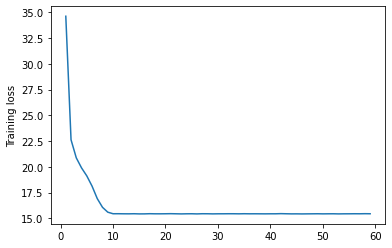

In [38]:
plt.plot(iters[1:], losses[1:])
plt.ylabel('Training loss')

### Lets try with new model now

In [138]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=256, num_layers=2, dropout=0.4, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256,121)
#         self.fc2 = nn.Linear(400, 121)
        self.flat = nn.Flatten()
    def forward(self, x, hidden = None):
        x = x.float()
        batch_size = x.shape[0]
#         hidden = (torch.zeros(2, batch_size, 3).to(device), torch.zeros(2, batch_size, 3).to(device))
        out, hidden = self.lstm(x,hidden)
        x = out[:,-1]
#         x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc1(x)
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x
    def forward2(self, x, hidden=None):
        x = x.float()
        batch_size = x.shape[0]
#         hidden = (torch.zeros(2, batch_size, 3).to(device), torch.zeros(2, batch_size, 3).to(device))
        out, hidden = self.lstm(x,hidden)
        x = out[:,-1]
#         x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc1(x)
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,60:100] = torch.exp(x[:,60:100])+1
        x[:,100:120] = torch.tanh(x[:,100:120])
        x[:,:20] = F.softmax(x[:,:20].clone(), dim = 1)
        return x, hidden

In [204]:
model3 = RNN2()
model3.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model3, data_train, data_train, device, batch_size = 64, num_iters=100)

  1%|          | 1/100 [00:16<28:02, 17.00s/it]

Epoch no  0    and training loss:  93231.76295038185


  2%|▏         | 2/100 [00:34<28:21, 17.37s/it]

Epoch no  1    and training loss:  -33677.548983138884


  3%|▎         | 3/100 [00:51<27:42, 17.14s/it]

Epoch no  2    and training loss:  -34134.0430770946


  4%|▍         | 4/100 [01:08<27:36, 17.26s/it]

Epoch no  3    and training loss:  -35750.42047118938


  5%|▌         | 5/100 [01:25<27:07, 17.13s/it]

Epoch no  4    and training loss:  -33023.78386878967


  6%|▌         | 6/100 [01:43<27:03, 17.27s/it]

Epoch no  5    and training loss:  -34175.81995010376


  7%|▋         | 7/100 [02:00<26:37, 17.17s/it]

Epoch no  6    and training loss:  -36490.1480140686


  8%|▊         | 8/100 [02:17<26:23, 17.21s/it]

Epoch no  7    and training loss:  -38492.412868499756


  9%|▉         | 9/100 [02:34<26:01, 17.16s/it]

Epoch no  8    and training loss:  -36585.74489593506


 10%|█         | 10/100 [02:51<25:46, 17.19s/it]

Epoch no  9    and training loss:  -40119.04587173424


 11%|█         | 11/100 [03:09<25:33, 17.23s/it]

Epoch no  10    and training loss:  -41102.92436218237


 12%|█▏        | 12/100 [03:26<25:08, 17.15s/it]

Epoch no  11    and training loss:  -43077.897071837346


 13%|█▎        | 13/100 [03:43<24:59, 17.23s/it]

Epoch no  12    and training loss:  -45947.3627967834


 14%|█▍        | 14/100 [04:00<24:34, 17.15s/it]

Epoch no  13    and training loss:  -50083.36175537107


 15%|█▌        | 15/100 [04:18<24:25, 17.24s/it]

Epoch no  14    and training loss:  -49365.95292663574


 16%|█▌        | 16/100 [04:35<24:02, 17.18s/it]

Epoch no  15    and training loss:  -51544.54137802124


 17%|█▋        | 17/100 [04:52<23:49, 17.22s/it]

Epoch no  16    and training loss:  -52285.091880798325


 17%|█▋        | 17/100 [05:01<24:31, 17.73s/it]


KeyboardInterrupt: 

In [170]:
torch.save(model3.state_dict(), 'modified_model6')

Text(0, 0.5, 'Training loss')

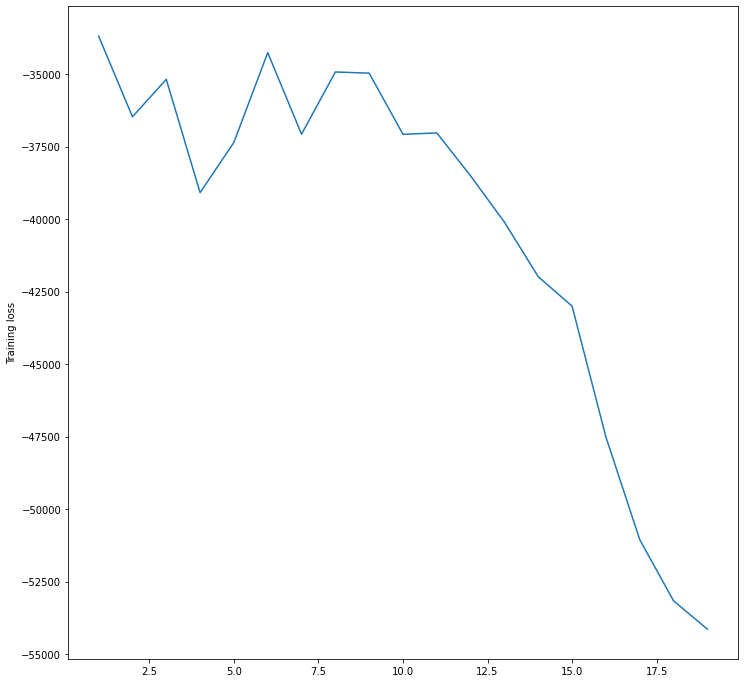

In [173]:
f, ax = plt.subplots(1,figsize=(12,12))
plt.plot(iters[1:], losses[1:])
# ax[1].plot(iters[1:], losses[1:])
plt.ylabel('Training loss')

Text(0, 0.5, 'Training loss')

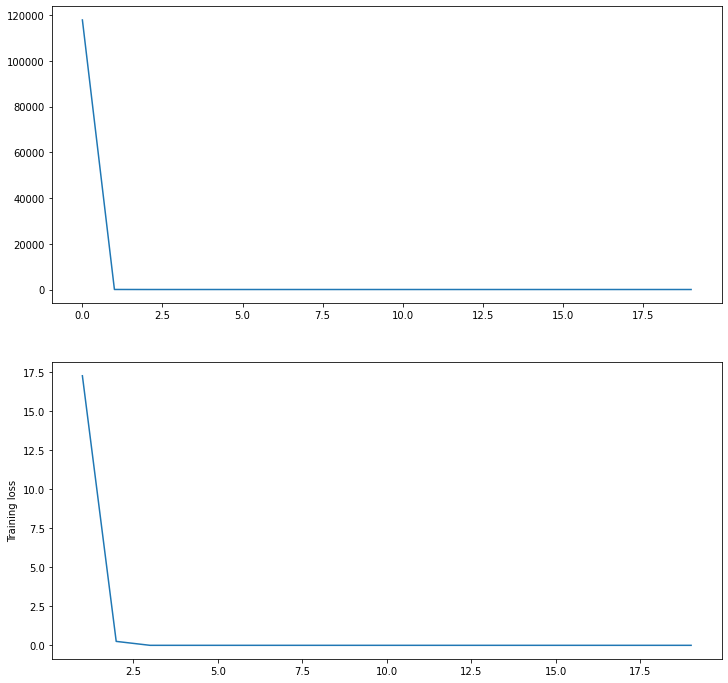

In [147]:
f, ax = plt.subplots(2,figsize=(12,12))
ax[0].plot(iters[0:], losses[0:])
ax[1].plot(iters[1:], losses[1:])
plt.ylabel('Training loss')

In [148]:
torch.save(model2.state_dict(), 'modified_model5')

In [46]:
model2 = RNN2()
model2.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model2, data_train, data_train, device, num_iters=20)

  5%|▌         | 1/20 [00:47<14:53, 47.04s/it]

Epoch no  0    and training loss:  466998.14370157354


 10%|█         | 2/20 [01:34<14:07, 47.06s/it]

Epoch no  1    and training loss:  33.99747406450859


 15%|█▌        | 3/20 [02:20<13:14, 46.75s/it]

Epoch no  2    and training loss:  26.409213232331883


 20%|██        | 4/20 [03:07<12:29, 46.81s/it]

Epoch no  3    and training loss:  26.38459124229334


 25%|██▌       | 5/20 [03:54<11:42, 46.82s/it]

Epoch no  4    and training loss:  26.380623936818218


 30%|███       | 6/20 [04:41<10:55, 46.80s/it]

Epoch no  5    and training loss:  26.382638117545795


 35%|███▌      | 7/20 [05:27<10:08, 46.81s/it]

Epoch no  6    and training loss:  26.379534833719422


 40%|████      | 8/20 [06:14<09:20, 46.72s/it]

Epoch no  7    and training loss:  26.382550372960125


 45%|████▌     | 9/20 [07:01<08:35, 46.85s/it]

Epoch no  8    and training loss:  26.384078171955245


 50%|█████     | 10/20 [07:47<07:47, 46.71s/it]

Epoch no  9    and training loss:  26.384648467718076


 55%|█████▌    | 11/20 [08:34<07:01, 46.80s/it]

Epoch no  10    and training loss:  26.385930195572598


 60%|██████    | 12/20 [09:21<06:13, 46.73s/it]

Epoch no  11    and training loss:  26.37900458527187


 65%|██████▌   | 13/20 [10:08<05:27, 46.72s/it]

Epoch no  12    and training loss:  26.387082274589698


 70%|███████   | 14/20 [10:54<04:40, 46.72s/it]

Epoch no  13    and training loss:  26.38063347700015


 75%|███████▌  | 15/20 [11:41<03:53, 46.73s/it]

Epoch no  14    and training loss:  26.3809386425472


 80%|████████  | 16/20 [12:28<03:07, 46.76s/it]

Epoch no  15    and training loss:  26.383689080205805


 85%|████████▌ | 17/20 [13:15<02:20, 46.74s/it]

Epoch no  16    and training loss:  26.376986614203556


 90%|█████████ | 18/20 [14:01<01:33, 46.70s/it]

Epoch no  17    and training loss:  26.386305956877667


 95%|█████████▌| 19/20 [14:48<00:46, 46.66s/it]

Epoch no  18    and training loss:  26.38366425071445


100%|██████████| 20/20 [15:34<00:00, 46.75s/it]

Epoch no  19    and training loss:  26.383267570484612


In [50]:
torch.save(model2.state_dict(), 'modified_model4')

In [97]:
model2 = RNN2()
model2.load_state_dict(torch.load('modified_model4'))
model2.to(device)

RNN2(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=121, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

### Generating sequences

In [174]:
def get_var(output):
#     pro = torch.zeros([label.shape[0]]).to(device)
    w = torch.zeros([20]).to(device)
    ux = torch.zeros([20]).to(device)
    uy = torch.zeros([20]).to(device)
    sx = torch.zeros([20]).to(device)
    sy = torch.zeros([20]).to(device)
    r = torch.zeros([20]).to(device)
    for i in range(20):
        w[i] = output[0,i]
        ux[i] = output[0,20+i]
        uy[i] = output[0,40+i]
        sx[i] = output[0,60+i]
        sy[i] = output[0,80+i]
        r[i] = output[0,100+i]
    return w,ux, uy, sx,sy,r, output[0,120]

def draw_one_sample(model, w , ux, uy, sx, sy, rho, flag):
    # draw Gaussian mixture
    idx, = random.choices(range(20), weights=w.data.tolist())
    x1 = torch.normal(ux[idx], sx[idx])  # size = 1,
    uy = uy + rho * (sx - sy) * (x1 - ux)
    sy = (1 - rho ** 2) ** 0.5 * sy
    x2 = torch.normal(uy[idx], sy[idx])  # $\Delta
    eos = torch.bernoulli(flag).view(1)
    return torch.tensor([x1, x2, eos]).view(1,1,3).to(device)


def generate(model, sample, hidden=None, n=100):
    res = []
    for i in range(n):
#         hidden = (torch.zeros(2, 1, 256).to(device), torch.zeros(2, 1, 256).to(device))
        out, hidden = model.forward2(sample, hidden)
        w,ux, uy, sx,sy,r, flag = get_var(out)
        sample = draw_one_sample(model, w,ux, uy, sx,sy,r, flag)
        res.append(sample.view(3).data.tolist())
    return res

In [256]:
train_loader = torch.utils.data.DataLoader([data_train[10000]], batch_size=1, shuffle=True)
res = []
for imgs, lab in train_loader:
    res = generate(model4, imgs.to(device))

In [257]:
px = []
py = []
for i in range(100):
    px.append(data_train[10000][0][i][0])
    py.append(data_train[10000][0][i][1])
for i in res:
    px.append(i[0])
    py.append(i[1])
len(px)

200

In [258]:
pox = [0.0]
poy = [0.0]
for i in range(200):
    pox.append(pox[-1]-px[i])
    poy.append(poy[-1]-py[i])

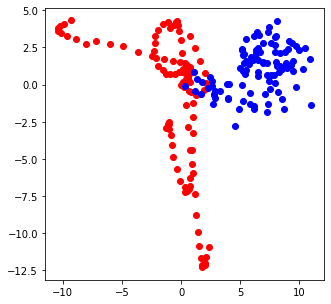

In [259]:
f, ax = plt.subplots(1,figsize=(5,5))
plt.scatter(pox[:101], poy[:101], color='red')
plt.scatter(pox[101:], poy[101:], color='blue')

In [ ]:
pox = [0.0]
poy = [0.0]
for i in range(400):
    pox.append(pox[-1]+px[i])
    poy.append(poy[-1]-py[i])

In [ ]:
plt.scatter(pox, poy)

In [ ]:
losses[-1]

**Last Values of Loss are nan**<br>
*The reason for this is exploding gradient problem in the LSTM. Now we will solve this by cliiping model parameters.*

In [ ]:
model = RNN()
model.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model, data, data, device, num_iters=60)

In [ ]:
model.parameters